In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import seaborn as sns
import gudhi as gd
from scipy.stats import norm

# Univariate

In [20]:
np.random.seed(100)

In [21]:
# True PDF for trimodal gaussian 
def true_pdf(x):
    pdf1 = norm.pdf(x, loc=-2, scale=0.5)
    pdf2 = norm.pdf(x, loc=2, scale=0.7)
    pdf3 = norm.pdf(x, loc=6, scale=0.7)
    return (pdf1 + pdf2 + pdf3) / 3

# Generate synthetic data
def generate_data(n_samples=1500):
    data1 = np.random.normal(loc=-2, scale=0.5, size=(n_samples//2, 1))
    data2 = np.random.normal(loc=2, scale=0.7, size=(n_samples//2, 1))
    data3 = np.random.normal(loc=6, scale=0.7, size=(n_samples//2, 1))
    return np.vstack([data1, data2, data3]).astype(np.float32)

# Compute KDE density estimate
def kde_density_tf(X, h, X_grid):
    X = tf.cast(X, dtype=tf.float32)
    X_grid = tf.cast(X_grid, dtype=tf.float32)
    h = tf.cast(h, dtype=tf.float32)

    def gaussian_kernel(x, y, h):
        return tf.exp(-tf.reduce_sum((x - y)**2, axis=-1) / (2 * h**2))

    def density_at_x(x_grid_point):
        kernels = gaussian_kernel(X, x_grid_point, h)
        return tf.reduce_mean(kernels) / (h * tf.sqrt(2 * np.pi))

    densities = tf.map_fn(density_at_x, X_grid)
    return densities

# Construct cubical complex from KDE density
def compute_cubical_persistence(X_grid, density_np):
    density_np = density_np / density_np.max()
    cc = gd.CubicalComplex(dimensions=[len(X_grid)], top_dimensional_cells=density_np)
    persistence = cc.persistence()
    return persistence

# Compute the topology-based loss function
def topology_loss_tf(persistence_diagram):
    lifetimes = np.array([d[1][1] - d[1][0] for d in persistence_diagram if d[1][1] < np.inf])
    if len(lifetimes) == 0:
        return tf.constant(np.inf, dtype=tf.float32)    
    lifetimes_tf = tf.constant(lifetimes, dtype=tf.float32)
    feature_complexity = tf.reduce_sum(-lifetimes_tf)
    betti_numbers = tf.cast(len(lifetimes), dtype=tf.float32)    
    return 0.8 * feature_complexity + 0.2 * betti_numbers

# Optimize by finding global minimum through line search
def find_optimal_bandwidth_tf(X, h_range):
    h_range_tf = tf.constant(h_range, dtype=tf.float32)
    X_grid_np = np.linspace(X.min() - 1, X.max() + 1, 200).reshape(-1, 1).astype(np.float32)
    X_grid_tf = tf.constant(X_grid_np, dtype=tf.float32)
    
    losses = []
    kde_results = []    
    for h in h_range_tf:
        with tf.GradientTape() as tape:
            tape.watch(h)
            density_tf = kde_density_tf(X, h, X_grid_tf)
            density_np = density_tf.numpy()
            persistence = compute_cubical_persistence(X_grid_np, density_np)
            loss = topology_loss_tf(persistence)
        
        losses.append(loss)
        kde_results.append((h.numpy(), X_grid_np, density_np))
    
    losses_np = np.array([l.numpy() for l in losses])
    optimal_h = h_range[np.argmin(losses_np)]
    return optimal_h, losses_np, kde_results

# Optimize by finding minimum with stability threshold
def find_optimal_bandwidth_stability_tf(X, h_range, stability_threshold=0.01):
    h_range_tf = tf.constant(h_range, dtype=tf.float32)
    X_grid_np = np.linspace(X.min() - 1, X.max() + 1, 200).reshape(-1, 1).astype(np.float32)
    X_grid_tf = tf.constant(X_grid_np, dtype=tf.float32)

    losses = []
    kde_results = []
    stable_h = None
    for i, h_tf in enumerate(h_range_tf):
        h = h_tf.numpy()
        with tf.GradientTape() as tape:
            tape.watch(h_tf)
            density_tf = kde_density_tf(X, h_tf, X_grid_tf)
            density_np = density_tf.numpy()
            persistence = compute_cubical_persistence(X_grid_np, density_np)
            loss = topology_loss_tf(persistence)

        losses.append(loss.numpy())
        kde_results.append((h, X_grid_np, density_np))
        if i > 1:
            change = abs(losses[-1] - losses[-2]) / abs(losses[-2]) if losses[-2] != 0 else 0
            if change < stability_threshold:
                if stable_h is None:
                    stable_h = h
                    break
    if stable_h is None:
        stable_h = h_range[np.argmin(losses)]
    return stable_h, np.array(losses), kde_results

In [22]:
X = generate_data(1500)

h_range = np.linspace(0.01, 1.5, 100)

optimal_h1, losses1, kde_results1 = find_optimal_bandwidth_tf(X, h_range)
optimal_h2, losses2, kde_results2 = find_optimal_bandwidth_stability_tf(X, h_range)

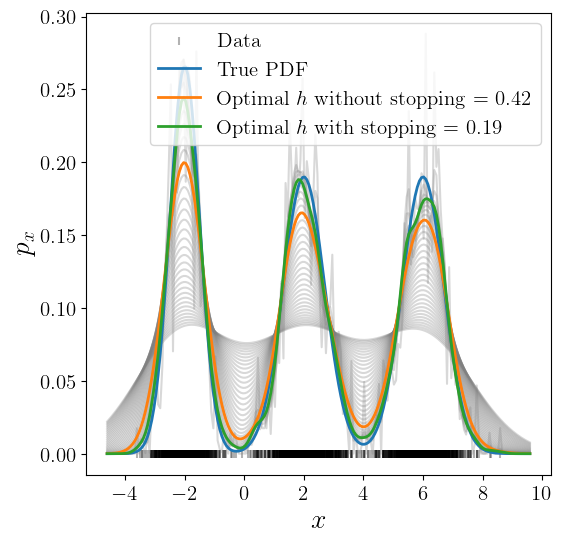

In [23]:
X_GRID = np.linspace(X.min() - 1, X.max() + 1, 200).reshape(-1, 1).astype(np.float32)

plt.figure(figsize=(6, 6))
for h, X_grid, density in kde_results1[::3]:
    # plt.plot(X_GRID, density, label=f"h={h:.2f}", alpha=0.3, color="gray")
    plt.plot(X_GRID, density, alpha=0.3, color="gray")
plt.scatter(X, np.zeros_like(X), alpha=0.3, color="black", marker="|", label="Data")
plt.plot(X_GRID, true_pdf(X_GRID), label="True PDF", linewidth=2)
plt.plot(X_GRID, kde_density_tf(X, optimal_h1, X_GRID).numpy(), label=f"Optimal $h$ without stopping = {optimal_h1:.2f}", linewidth=2)
plt.plot(X_GRID, kde_density_tf(X, optimal_h2, X_GRID).numpy(), label=f"Optimal $h$ with stopping = {optimal_h2:.2f}", linewidth=2)
plt.legend(fontsize=15, loc="upper right")
plt.xlabel(fr"$x$", fontsize=20)
plt.ylabel(fr"$p_x$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("KDEs_1d.png", dpi=300, bbox_inches="tight")

plt.show()

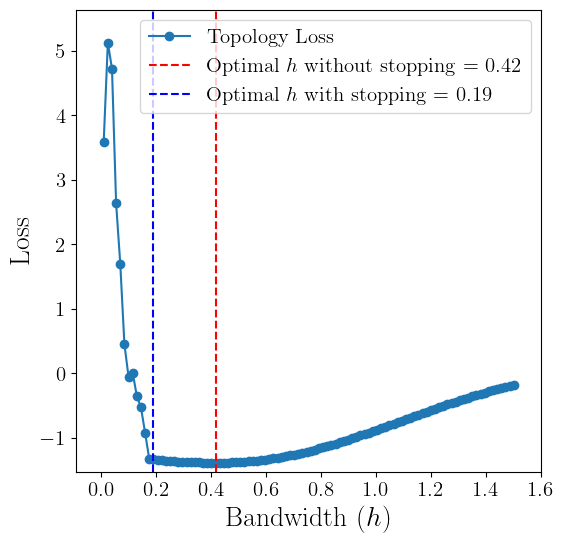

In [26]:
plt.figure(figsize=(6, 6))
plt.plot(h_range, losses1, marker='o', label="Topology Loss")
plt.axvline(optimal_h1, color='r', linestyle='--', label=f"Optimal $h$ without stopping = {optimal_h1:.2f}")
plt.axvline(optimal_h2, color='b', linestyle='--', label=f"Optimal $h$ with stopping = {optimal_h2:.2f}")
plt.xlabel(f"Bandwidth ($h$)", fontsize=20)
plt.ylabel(f"Loss", fontsize=20)
plt.legend(fontsize=15, loc="upper right")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(h_range[0]-0.1, h_range[-1]+0.1)
plt.ylim(np.min(losses1) * 1.1, np.max(losses1) * 1.1)
plt.savefig("loss_1d_full.png", dpi=300, bbox_inches="tight")

plt.show()

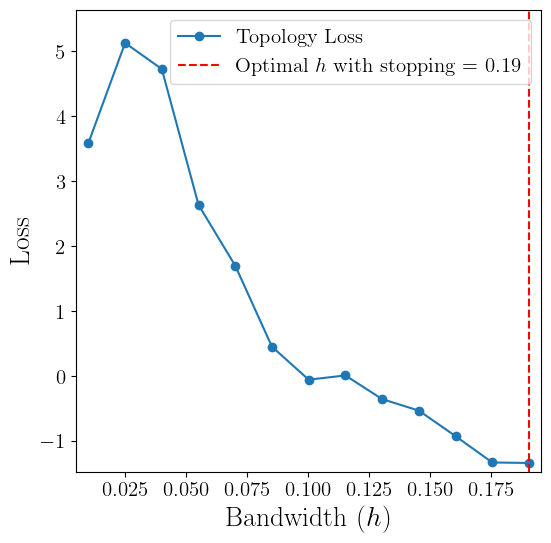

In [27]:
plt.figure(figsize=(6, 6))
plt.plot(h_range[:len(losses2)], losses2, marker='o', label="Topology Loss")
plt.axvline(optimal_h2, color='r', linestyle='--', label=f"Optimal $h$ with stopping = {optimal_h2:.2f}")
plt.xlabel(f"Bandwidth ($h$)", fontsize=20)
plt.ylabel(f"Loss", fontsize=20)
plt.legend(fontsize=15, loc="upper right")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(h_range[0]-0.005, h_range[len(losses2)-1]+0.005)
plt.ylim(np.min(losses2) * 1.1, np.max(losses2) * 1.1)
plt.savefig("loss_1d.png", dpi=300, bbox_inches="tight")

plt.show()

# KDE Comparison (Univariate)

In [28]:
optimal_X_grid = np.linspace(X.min() - 1, X.max() + 1, 200)

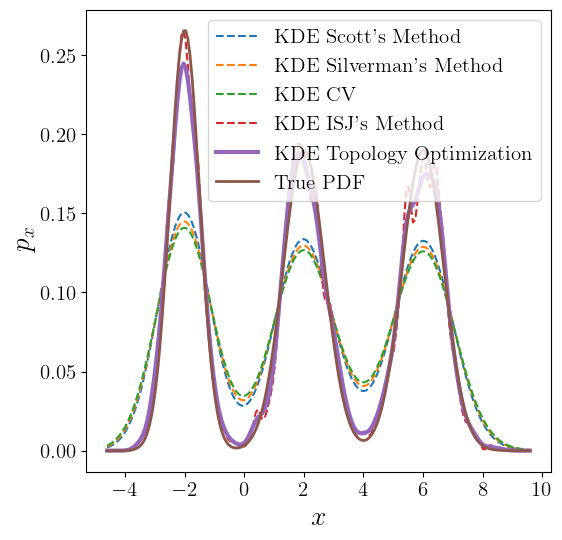

In [29]:
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from KDEpy import FFTKDE

# Plot the results
plt.figure(figsize=(6, 6))

pdf1 = gaussian_kde(X[:, 0], bw_method='scott')(optimal_X_grid)
plt.plot(optimal_X_grid, pdf1, '--', label="KDE Scott's Method")

pdf2 = gaussian_kde(X[:, 0], bw_method='silverman')(optimal_X_grid)
plt.plot(optimal_X_grid, pdf2, '--', label="KDE Silverman's Method")

grid_search = GridSearchCV(KernelDensity(), {'bandwidth': h_range}, cv=5)
grid_search.fit(X)
pdf3 = gaussian_kde(X[:, 0], bw_method=grid_search.best_params_['bandwidth'])(optimal_X_grid)
plt.plot(optimal_X_grid, pdf3, '--', label="KDE CV")

pdf4 = FFTKDE(bw='ISJ').fit(X[:, 0]).evaluate(optimal_X_grid)
plt.plot(optimal_X_grid, pdf4.flatten(), '--', label="KDE ISJ's Method")

plt.plot(optimal_X_grid, kde_density_tf(X, optimal_h2, optimal_X_grid).numpy(), label='KDE Topology Optimization', linewidth=3)
plt.plot(optimal_X_grid, true_pdf(optimal_X_grid), label="True PDF", linewidth=2)

plt.legend(fontsize=15, loc="upper right")
plt.xlabel(fr"$x$", fontsize=20)
plt.ylabel(fr"$p_x$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("KDEs_comparison_1d.png", dpi=300, bbox_inches="tight")

plt.show()

In [30]:
kde_curves_1d = [pdf1, pdf2, pdf3, pdf4]
kde_curves_1d.append(kde_density_tf(X, optimal_h2, optimal_X_grid).numpy())
kde_curves_1d.append(true_pdf(optimal_X_grid))

## Measures

In [31]:
def kl_divergence(pdf_true, kde, grid):
    dx = np.diff(grid).mean()
    pdf_true = pdf_true / (np.sum(pdf_true) * dx)
    kde = kde / (np.sum(kde) * dx)
    kde = np.maximum(kde, 1e-10)
    kl_div = np.sum(pdf_true * np.log(pdf_true / kde) * dx)    
    return kl_div

x_grid_1d = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)

klds = [kl_divergence(true_pdf(optimal_X_grid), kde_curves_1d[i], x_grid_1d) for i in range(len(kde_curves_1d))]

print("KLD for each 1D KDE curve:")
for i, ll in enumerate(klds):
    print(f"KLD {i+1}: {ll}")

KLD for each 1D KDE curve:
KLD 1: 0.13891528625148072
KLD 2: 0.15668828531498713
KLD 3: 0.17028710178374146
KLD 4: 0.008887382109244814
KLD 5: 0.00752817741036166
KLD 6: 0.0


In [32]:
from scipy.stats import wasserstein_distance
def earth_movers_distance_1d(pdf_true_normalized_1d, kde_normalized_1d, grid_1d):
    emd_value = wasserstein_distance(grid_1d, grid_1d, u_weights=pdf_true_normalized_1d, v_weights=kde_normalized_1d)
    return emd_value

emds = [earth_movers_distance_1d(true_pdf(optimal_X_grid), kde_curves_1d[i], x_grid_1d) for i in range(len(kde_curves_1d))]

print("EMD for each 1D KDE curve:")
for i, ll in enumerate(emds):
    print(f"EMD {i+1}: {ll}")

EMD for each 1D KDE curve:
EMD 1: 0.20872258572912752
EMD 2: 0.2263412337661855
EMD 3: 0.23947793915905213
EMD 4: 0.02368026135496767
EMD 5: 0.03089604907467057
EMD 6: 0.0


# Running Loop for 2500 Tests

In [ ]:
from datetime import datetime

In [ ]:
h_range = np.linspace(0.01, 1.5, 100)

for i in range(2500):

    print(i)

    np.random.seed(int(datetime.now().timestamp()))
    
    X = generate_data(1500)
    optimal_h, losses, kde_results = find_optimal_bandwidth_stability_tf(X, h_range)

    optimal_X_grid = np.linspace(X.min() - 1, X.max() + 1, 200)
    true_pdf_1D = true_pdf(optimal_X_grid)

    pdf1 = gaussian_kde(X[:, 0], bw_method='scott')(optimal_X_grid)

    pdf2 = gaussian_kde(X[:, 0], bw_method='silverman')(optimal_X_grid)

    grid_search = GridSearchCV(KernelDensity(), {'bandwidth': h_range}, cv=5)
    grid_search.fit(X)
    pdf3 = gaussian_kde(X[:, 0], bw_method=grid_search.best_params_['bandwidth'])(optimal_X_grid)

    pdf4 = FFTKDE(bw='ISJ').fit(X[:, 0]).evaluate(optimal_X_grid)

    kde_curves_1d = []
    kde_curves_1d = [pdf1, pdf2, pdf3, pdf4]
    kde_curves_1d.append(gaussian_kde(X[:, 0], bw_method=optimal_h)(optimal_X_grid))
    kde_curves_1d.append(true_pdf_1D)

    x_grid_1d = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    klds = [kl_divergence(true_pdf_1D, kde_curves_1d[i], x_grid_1d) for i in range(len(kde_curves_1d))]
    emds = [earth_movers_distance_1d(true_pdf_1D, kde_curves_1d[i], x_grid_1d) for i in range(len(kde_curves_1d))]

    np.save(fr'KLD_{i}.npy', np.array(klds))
    np.save(fr'EMD_{i}.npy', np.array(emds))


In [ ]:
klds = []
emds = []
for i in range(2500):
    klds.append(np.load(fr'KLD_{i}.npy'))
    emds.append(np.load(fr'EMD_{i}.npy'))

klds = np.array(klds)
emds = np.array(emds)

In [ ]:
print(np.mean(klds[~np.isinf(klds).any(axis=1)], axis=0))
print(np.mean(emds[~np.isinf(emds).any(axis=1)], axis=0))

In [ ]:
print(np.std(klds[~np.isinf(klds).any(axis=1)], axis=0))
print(np.std(emds[~np.isinf(emds).any(axis=1)], axis=0))